In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv("costsensitiveregression.csv")

# Number of instances
num_instances = len(df)

# Mean false negative cost
mean_fn_cost = df['FNC'].mean()

print("Number of instances:", num_instances)
print("Mean false negative cost:", mean_fn_cost)


Number of instances: 147636
Mean false negative cost: 533.4049116733859


In [2]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test, CFN_train, CFN_test = train_test_split(
    df[['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS', 'AH', 'AN']],
    df['Status'],
    df['FNC'],
    test_size=0.2
)


In [3]:

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [4]:

# Define the costs for false positives, true positives, and true negatives
CFP = 6  # Cost for false positives
CTP = 6  # Cost for true positives
CTN = 0  # Cost for true negatives


# Bahnsen's approach

In [5]:

# Calculate the predicted probabilities for the positive class using the training set
train_probabilities = model.predict_proba(X_train)[:, 1]

# Compute individual costs for each instance in the training set
train_individual_costs = np.where(y_train == 1, (1 - train_probabilities) * CFN_train, train_probabilities * CFP)

# Define the cost function
def cost_function(theta, X, y, probabilities, FN_cost, CFP, CTP, CTN):
    # Calculate the predicted probabilities using the logistic function
    h = 1 / (1 + np.exp(-np.dot(X, theta)))
    
    # Compute the costs for true positive, false positive, true negative, and false negative predictions
    TP_cost = y * (h * CTP + (1 - h) * CTN)
    FP_cost = (1 - y) * (h * CFP + (1 - h) * FN_cost)
    
    # Sum up the costs for all instances
    total_cost = np.sum(TP_cost + FP_cost)
    
    # Return the average cost
    return total_cost / len(y)

# Initialize the parameters
initial_theta = np.zeros(X_train.shape[1])


In [6]:

# Optimize the cost function using scipy's minimize function
result = minimize(cost_function, initial_theta, args=(X_train, y_train, train_probabilities, CFN_train, CFP, CTP, CTN))

# Extract the optimized parameters
optimal_theta = result.x

# Output the optimized parameters
print("Optimized parameters:", optimal_theta)


Optimized parameters: [1.91094496 0.76614114 0.12204076 0.00838728 0.01296724 0.02348521
 0.01489893 0.06969794 0.17890809 0.0245483  0.00972095]


## Results

In [7]:

# Calculate the predicted probabilities for the positive class using the testing set
test_probabilities = model.predict_proba(X_test)[:, 1]

# Compute individual costs for each instance in the testing set
test_individual_costs = np.where(y_test == 1, (1 - test_probabilities) * CFN_test, test_probabilities * CFP)

# Make predictions on the testing dataset
predictions = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

# Output the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.8633500406393931
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     20685
           1       0.80      0.72      0.76      8843

    accuracy                           0.86     29528
   macro avg       0.84      0.82      0.83     29528
weighted avg       0.86      0.86      0.86     29528



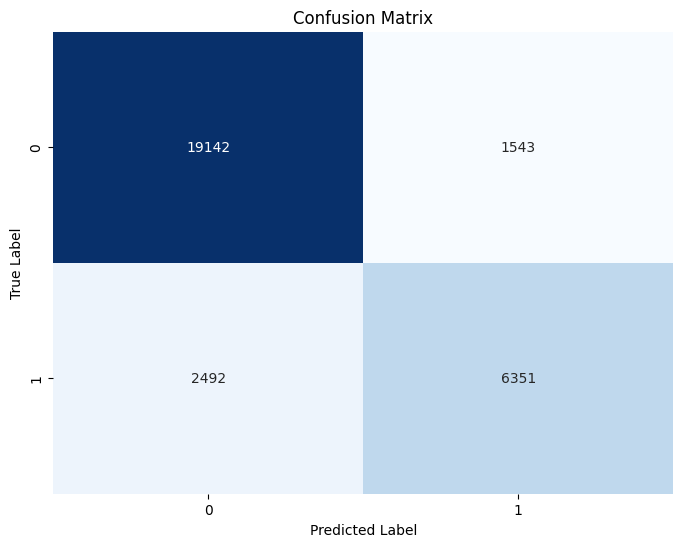

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



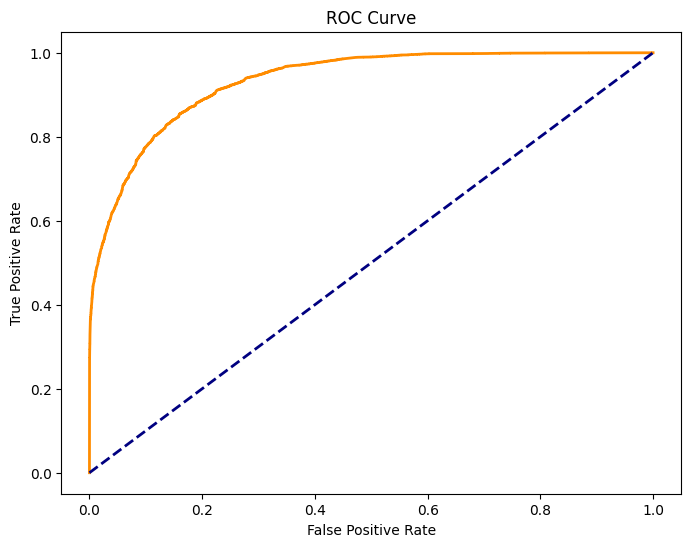

In [9]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probabilities)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


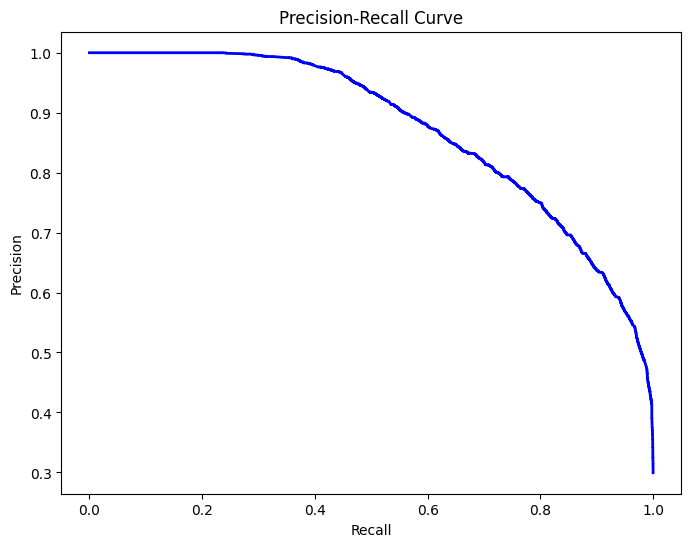

In [10]:

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, test_probabilities)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Nikou Gunnemann's approach

In [11]:

# Define the cost function
def cost_function(theta, X, y, fn_cost, CFP, CTP, CTN):
    # Calculate the predicted values using the linear function
    y_pred = np.dot(X, theta)
    
    # Compute the costs for true positive, false positive, true negative, and false negative predictions
    TP_cost = np.sum(np.maximum(0, (y_pred - 0.5) * CTP))
    FP_cost = np.sum(np.maximum(0, (0.5 - y_pred) * CFP))
    FN_cost = np.sum(np.maximum(0, (0.5 - y_pred) * fn_cost))
    
    # Calculate the total cost
    total_cost = TP_cost + FP_cost + FN_cost
    
    # Return the total cost
    return total_cost

# Initialize the parameters
initial_theta = np.zeros(X_train.shape[1])


In [12]:

# Optimize the cost function using scipy's minimize function
result = minimize(cost_function, initial_theta, args=(X_train, y_train, CFN_train, CFP, CTP, CTN))

# Extract the optimized parameters
optimal_theta = result.x

# Output the optimized parameters
print("Optimized parameters:", optimal_theta)


Optimized parameters: [ 2.22664663e-02  2.16350438e-02  2.79224421e-02  3.66886310e-03
  1.86261522e-03  6.68973234e-03  4.60544167e+00 -8.60289919e-04
 -7.34151759e-04 -5.24224481e-03 -1.09990211e-03]


## Results

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the testing dataset using the optimized parameters
y_pred_test = np.dot(X_test, optimal_theta)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# Output the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 13.617555378438482
Mean Absolute Error (MAE): 0.814404996885878
Root Mean Squared Error (RMSE): 3.6901972004810912


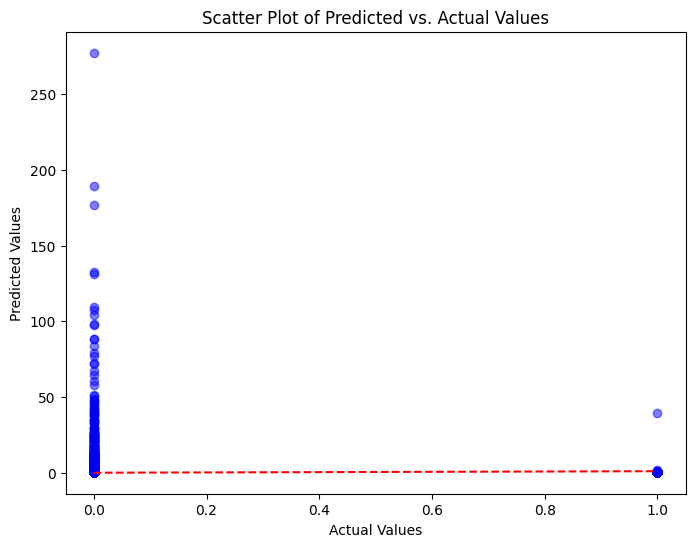

In [14]:
# Scatter Plot of Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')
plt.show()


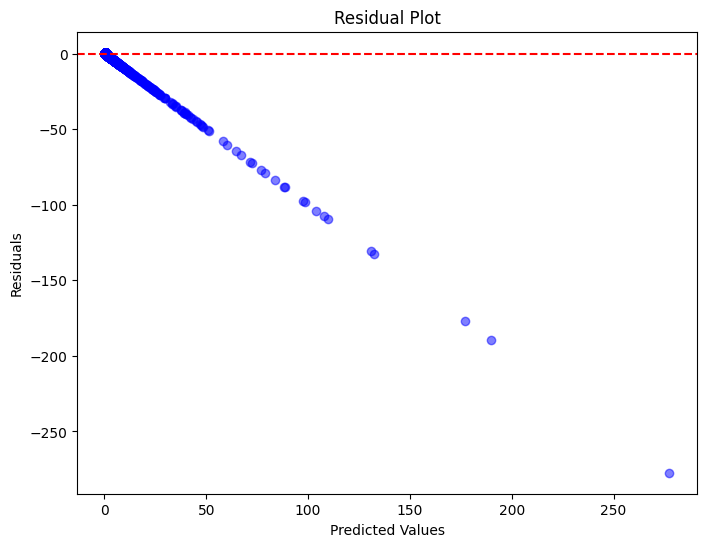

In [15]:

# Residual Plot
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


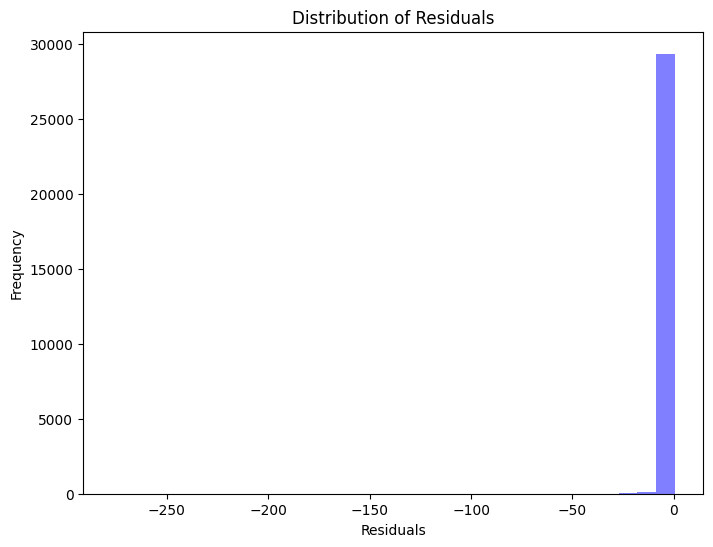

In [16]:

# Distribution of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
